## ChestXNet: Pneumonia Detection on Chest X-rays with Convolutional Neural Networks

In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd 
import os
from glob import glob
import matplotlib.pyplot as plt

from itertools import chain
from sklearn.model_selection import GroupShuffleSplit
from random import sample
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

Using TensorFlow backend.


## Processing of the metadata:

In [2]:
# Reading all full image filepaths into a dataframe for easier manipulation
# Loading the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
79078,00019406_008.png,Emphysema,8,19406,55,M,PA,2754,2991,0.143,0.143,NaN,/data/images_009/images/00019406_008.png
82808,00020341_000.png,No Finding,0,20341,64,M,PA,2992,2991,0.143,0.143,NaN,/data/images_009/images/00020341_000.png
72832,00017948_000.png,No Finding,0,17948,48,M,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00017948_000.png


In [3]:
# Splitting the "Finding Labels" columns to have a binary column for each disease
disease_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].apply(lambda x: x.split('|')).tolist())))

for label in disease_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].apply(lambda x: 1.0 if label in x else 0)

# Creating  a new column called 'pneumonia_class' for binary classification
all_xray_df['pneumonia_class']=all_xray_df['Pneumonia'].replace({0.0:'Negative',1.0:'Positive'})
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative


In [4]:
# Rechecking, whether there are NaN values
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
 12  path                         112120 non-null  object 
 13 

## Creating training and testing data:

In [5]:
# 80/20 TRAIN / VALID SPLIT 1st step:
# Goal: no Patient overlap between the training and the validation set

# Splitting data in such a way that there is no Patient ID overlap between the training and validation set
train_inds, val_inds = next(GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 16).split(all_xray_df, groups=all_xray_df['Patient ID']))

# Rechecking, if the splitting worked as intendend
print(f'Patient ID overlap between train and test datasets: {np.intersect1d(train_inds, val_inds)}') 

train_df = all_xray_df.loc[train_inds]
valid_df = all_xray_df.loc[val_inds] 

Patient ID overlap between train and test datasets: []


- There is no patient ID overlap between train and validation set.

In [6]:
# 80/20 TRAIN / VALID SPLIT 2nd step:
# Goal: 80% of positive cases in the training set, the rest in the validation set

# Checking how much pneumonia cases are there in train and validation datasets
train_df_pneumonia_cases = len(train_df[train_df.Pneumonia==1])
valid_df_pneumonia_cases = len(valid_df[valid_df.Pneumonia==1])
print(f'Pneumonia cases in the training set: {train_df_pneumonia_cases}.')
print(f'Pneumonia cases in the validation set: {valid_df_pneumonia_cases}.')
print(f'Percentage of pneumonia cases, which were assigned to the training set:{train_df_pneumonia_cases/(train_df_pneumonia_cases + valid_df_pneumonia_cases)*100}%')


Pneumonia cases in the training set: 1157.
Pneumonia cases in the validation set: 274.
Percentage of pneumonia cases, which were assigned to the training set:80.85255066387141%


- The percentage of pneumonia cases in the training set is very close to the percentage of all cases contained in the     training  set, which was the goal of the second stage of train / valid split.

In [7]:
# TRAIN / VALID SPLIT 3rd step:
# Goal: Balacing the training dataset for negative and positive cases

print(f'Percentage of postive cases in the training set before balancing: {train_df.Pneumonia.sum()/len(train_df)*100}%.')

postitive_inds = train_df[train_df.Pneumonia==1].index.tolist()
negative_inds = train_df[train_df.Pneumonia==0].index.tolist()

negative_inds_sample = sample(negative_inds, len(postitive_inds))
train_df = train_df.loc[postitive_inds + negative_inds_sample]

train_df.Pneumonia.sum()/len(train_df)
print(f'Percentage of postive cases in the training set after balancing: {train_df.Pneumonia.sum()/len(train_df)*100}%.')

Percentage of postive cases in the training set before balancing: 1.2899988850485005%.
Percentage of postive cases in the training set after balancing: 50.0%.


In [8]:
# TRAIN / VALID SPLIT 3rd step:
# Goal: Percentage of pneumonia cases in validation set should reflect the percentage of cases in the real clinical setting
print(f'Percentage of postive cases in the dataset before train/valid split: {all_xray_df.Pneumonia.sum()/len(all_xray_df)*100}%.')
print(f'Percentage of postive cases in the validation set: {valid_df.Pneumonia.sum()/len(valid_df)*100}%.')

Percentage of postive cases in the dataset before train/valid split: 1.2763110952550838%.
Percentage of postive cases in the validation set: 1.2215782434239857%.


- Those values are close to each other, thus no further manipulation of the validation dataset will be performed.

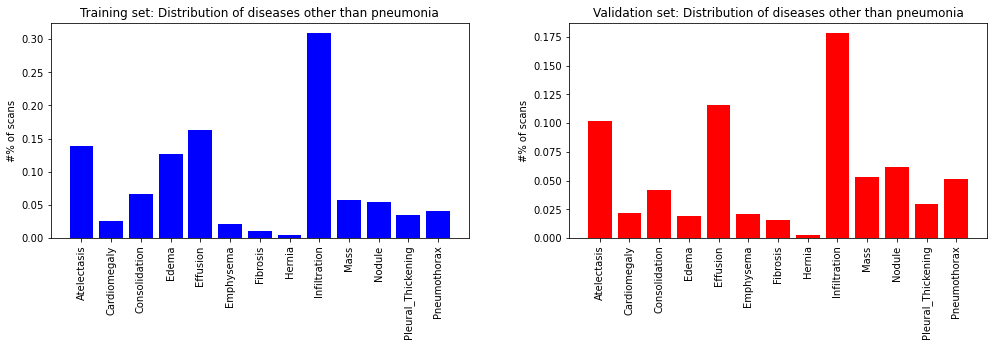

In [9]:
# TRAIN / VALID SPLIT 4th step:
# Goal: recheck the distributions in the train and validation sets.

# Distribution of diseases other than pneumonia that are present in both datasets

disease_labels_no_pneumonia = np.delete(disease_labels, [10,13]) #deleting "no finding" and "pneumonia" label
disease_labels_no_pneumonia_occurance_train = train_df.loc[:,disease_labels_no_pneumonia].sum()/len(train_df)
disease_labels_no_pneumonia_occurance_valid = valid_df.loc[:,disease_labels_no_pneumonia].sum()/len(valid_df)

fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].bar(disease_labels_no_pneumonia, disease_labels_no_pneumonia_occurance_train, color='blue')
ax[0].set_title("Training set: Distribution of diseases other than pneumonia")
ax[0].set_ylabel('#% of scans')
ax[0].set_xticklabels(disease_labels_no_pneumonia, rotation=90)
ax[1].bar(disease_labels_no_pneumonia, disease_labels_no_pneumonia_occurance_valid, color='red')
ax[1].set_title("Validation set: Distribution of diseases other than pneumonia")
ax[1].set_ylabel('#% of scans')
ax[1].set_xticklabels(disease_labels_no_pneumonia, rotation=90)
fig.tight_layout(pad=5.0)

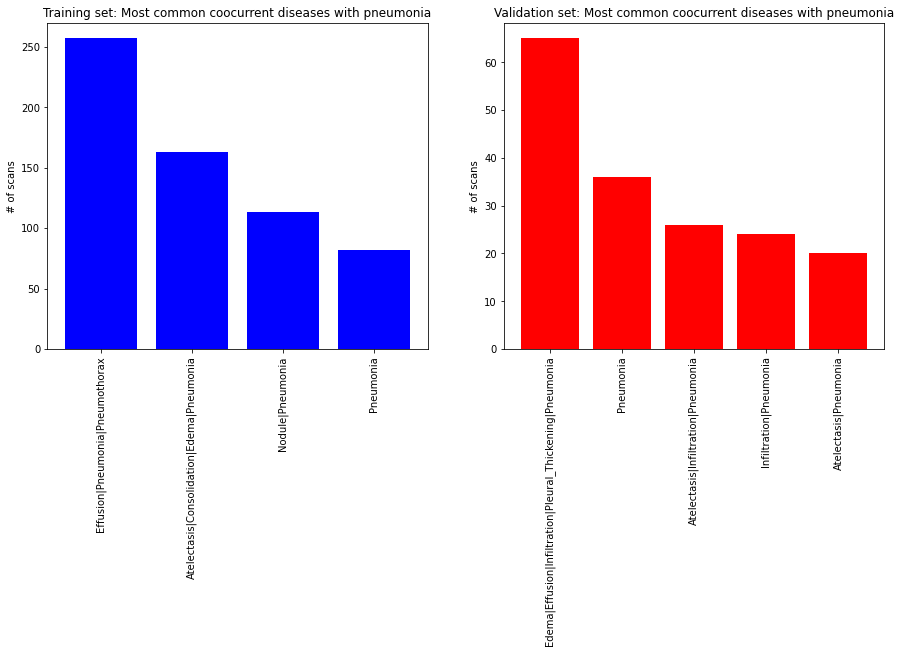

In [10]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].bar(train_df[train_df.Pneumonia==1]['Finding Labels'][0:5], 
          train_df[train_df.Pneumonia==1]['Finding Labels'].value_counts()[0:5], color='blue')
ax[0].set_title("Training set: Most common coocurrent diseases with pneumonia")
ax[0].set_xticklabels(train_df[train_df.Pneumonia==1]['Finding Labels'][0:5], rotation=90)
ax[0].set_ylabel('# of scans')

ax[1].bar(valid_df[valid_df.Pneumonia==1]['Finding Labels'][0:5], 
          valid_df[valid_df.Pneumonia==1]['Finding Labels'].value_counts()[0:5], color='red')
ax[1].set_title("Validation set: Most common coocurrent diseases with pneumonia")
ax[1].set_xticklabels(valid_df[valid_df.Pneumonia==1]['Finding Labels'][0:5], rotation=90)
ax[1].set_ylabel('# of scans')

plt.show()

- The biggest difference in distribution of the diseases in the train and the validation set is for Edema and Pneumothorax.
    
    Pneumothorax together with Effusion is the most co-occurent disease with pneumonia in the training set, while Edema together with Effusion, Infiltration and Pleural Thickening in the validation set.

    This has to be kept in mind, as a possible source of inaccuracy of the model

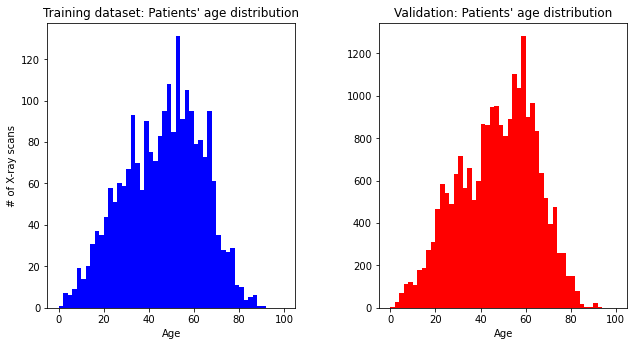

In [11]:
# Distribution of age in the train and the validaton set
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].hist(train_df['Patient Age'], bins=50, range=(0,100), color='blue')
ax[0].set_title("Training dataset: Patients' age distribution")
ax[0].set_xlabel('Age')
ax[0].set_ylabel('# of X-ray scans')
ax[1].hist(valid_df['Patient Age'], bins=50, range=(0,100), color='red')
ax[1].set_title("Validation: Patients' age distribution")
ax[1].set_xlabel('Age')
fig.tight_layout(pad=5.0)
plt.show()

- The age distribution in the training and the validation dataset is similar.

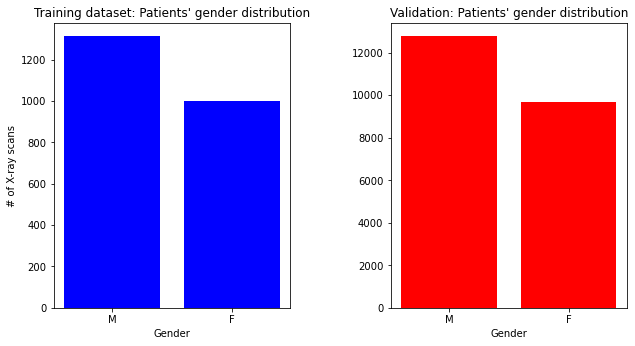

In [12]:
# Distribution of patients' gender in the train and the validaton set
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].bar(train_df['Patient Gender'].unique(),train_df['Patient Gender'].value_counts(), color='blue')
ax[0].set_title("Training dataset: Patients' gender distribution")
ax[0].set_xlabel('Gender')
ax[0].set_ylabel('# of X-ray scans')
ax[1].bar(valid_df['Patient Gender'].unique(), valid_df['Patient Gender'].value_counts(), color='red')
ax[1].set_title("Validation: Patients' gender distribution")
ax[1].set_xlabel('Gender')
fig.tight_layout(pad=5.0)
plt.show()

In [13]:
M_F_ratio_train = train_df['Patient Gender'].value_counts()[0] / train_df['Patient Gender'].value_counts()[1] 
print(f'M/F ratio: Training dataset {M_F_ratio_train:.2}.')

M_F_ratio_valid = valid_df['Patient Gender'].value_counts()[0] / valid_df['Patient Gender'].value_counts()[1] 
print(f'M/F ratio: Validation dataset {M_F_ratio_valid:.2}.')

M/F ratio: Training dataset 1.3.
M/F ratio: Validation dataset 1.3.


- The Male/Female ratio in the training and the validation dataset is the same.

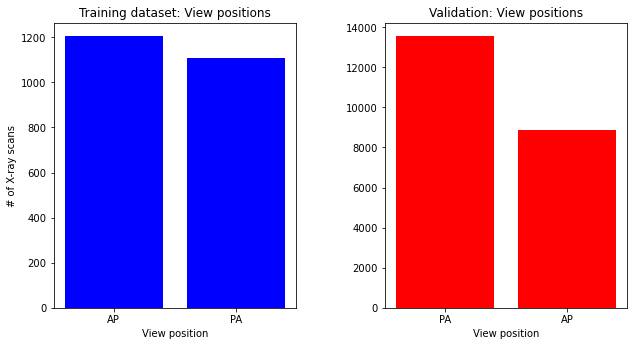

In [14]:
# Distribution of view position in the train and the validaton set
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].bar(train_df['View Position'].unique(),train_df['View Position'].value_counts(), color='blue')
ax[0].set_title("Training dataset: View positions")
ax[0].set_xlabel('View position')
ax[0].set_ylabel('# of X-ray scans')
ax[1].bar(valid_df['View Position'].unique(), valid_df['View Position'].value_counts(), color='red')
ax[1].set_title("Validation: View positions")
ax[1].set_xlabel('View position')
fig.tight_layout(pad=5.0)
plt.show()

In [15]:
PA_AP_ratio_train = train_df['View Position'].value_counts()[0] / train_df['View Position'].value_counts()[1] 
print(f'PA/AP ratio: Training dataset {PA_AP_ratio_train:.2}.')

PA_AP_ratio_valid = valid_df['View Position'].value_counts()[0] / valid_df['View Position'].value_counts()[1] 
print(f'PA/AP ratio: Validation dataset {PA_AP_ratio_valid:.2}.')

PA/AP ratio: Training dataset 1.1.
PA/AP ratio: Validation dataset 1.5.


- The PA/AP ratio in the training and the validation dataset is different.

    This has to be kept in mind as:
    - heart size is exaggerated in the AP projection and the X-ray beam is more divergent.
    - AP projection images are of lower quality then PA images.
    
    Ref: https://www.radiologymasterclass.co.uk/tutorials/chest/chest_quality/chest_xray_quality_projection 

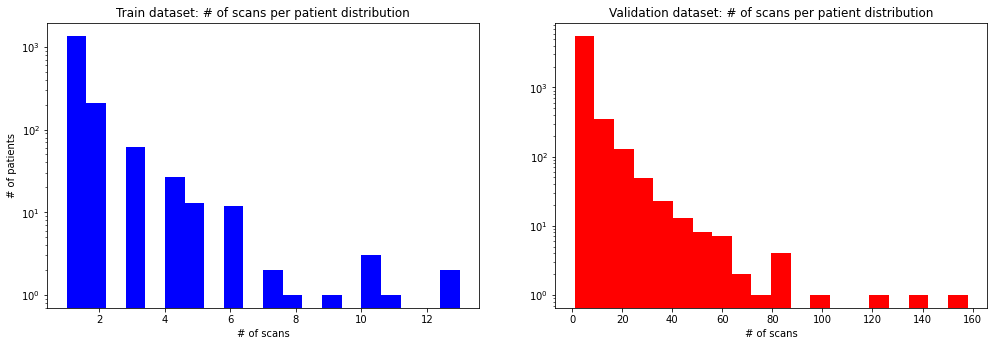

In [16]:
# Distribution of number of scans per patient in the train and the validaton set
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].hist(train_df['Patient ID'].value_counts(), bins=20, log=True, color='blue')
ax[0].set_title("Train dataset: # of scans per patient distribution")
ax[0].set_xlabel('# of scans')
ax[0].set_ylabel('# of patients')
ax[1].hist(valid_df['Patient ID'].value_counts(), bins=20, log=True, color='red')
ax[1].set_title("Validation dataset: # of scans per patient distribution")
ax[1].set_xlabel('# of scans')
fig.tight_layout(pad=5.0)
plt.show()

# Model-building & training

In [17]:
# Function definitions for data augumantation and for training and validation generator

def image_augmentation_train(rescale=1./255.0, height_shift_range=0.1, width_shift_range=0.1, 
                                rotation_range=2, zoom_range=0.01):
    
    """Function returing training image data generator with normalized and augumented images"""
    
    train_idg = ImageDataGenerator(rescale = rescale,
                            height_shift_range = height_shift_range,
                            width_shift_range = width_shift_range,
                            rotation_range = rotation_range,
                            zoom_range = zoom_range)
    
    return train_idg



def image_augmentation_valid(rescale=1./255.0):
    
    """Function returing validation image data generator with normalized images"""
       
    valid_idg = ImageDataGenerator(rescale = rescale)
    
    return valid_idg




def make_train_gen(train_idg, train_df, directory=None, x_col='path', y_col='pneumonia_class',
                  class_mode='binary', target_size=(224, 224), batch_size=20):
    
    """Function returing training generator, reading the image paths to load from dataframe"""
    
    train_gen = train_idg.flow_from_dataframe(dataframe = train_df, 
                                         directory=directory,
                                         x_col = x_col,
                                         y_col = y_col,
                                         class_mode = class_mode,
                                         target_size = target_size, 
                                         batch_size = batch_size)     

    return train_gen




def make_valid_gen(valid_idg, valid_df, directory=None, x_col='path', y_col='pneumonia_class',
                  class_mode='binary', target_size=(224, 224), batch_size=20):
    
    """Function returing validation generator, reading the image paths to load from dataframe"""
    
    valid_gen = valid_idg.flow_from_dataframe(dataframe = valid_df, 
                                             directory = directory, 
                                             x_col = x_col,
                                             y_col = y_col,
                                             class_mode = class_mode,
                                             target_size = target_size, 
                                             batch_size = batch_size) 
    
    return valid_gen

In [18]:
# Pulling a single large batch of random validation data for testing after each epoch:
valid_gen = make_valid_gen(image_augmentation_valid(), valid_df)
valX, valY = valid_gen.next()

Found 22430 validated image filenames belonging to 2 classes.


Found 2314 validated image filenames belonging to 2 classes.


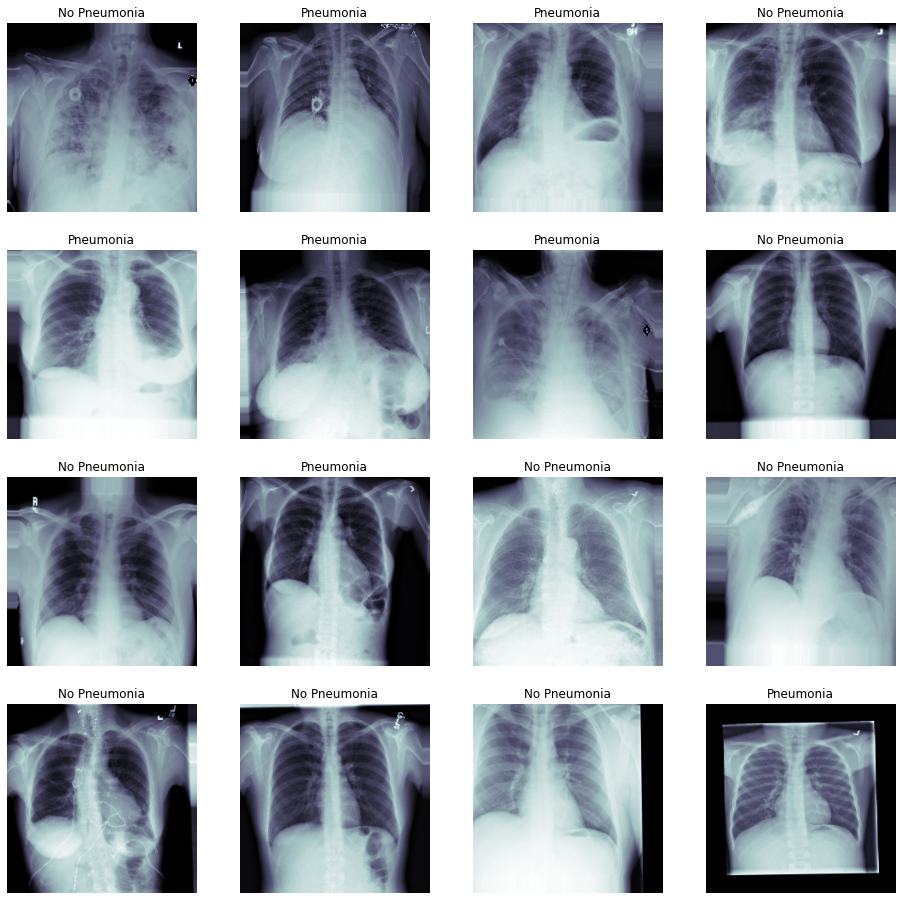

In [19]:
# Looking at some examples of our augmented training data  
# to understand the extent to which data is being manipulated prior to training, 

train_idg = image_augmentation_train()
train_gen = make_train_gen(train_idg, train_df)

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))

for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Building the model: 

In [20]:
# Loading VGG16 pre-trained model and displaying its layers

model = VGG16(include_top=True, weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [21]:
def load_pretrained_model(pretrained_model=VGG16, weights='imagenet', transfer_layer='block5_pool', 
                          transfer_layer_idx=18):
    
    """Function loading pre-trained model with defined weights and defined transfer layer"""
    
    model = pretrained_model(include_top=True, weights=weights)
    transfer_layer = model.get_layer(transfer_layer)
    pretrained_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # freezing layers till transfer_layer
    for layer in pretrained_model.layers[0:transfer_layer_idx]:
        layer.trainable = False
    
    # rechecking, if the freezeing was performed correctly
    for layer in pretrained_model.layers:
        print(layer.name, layer.trainable)
    
    return pretrained_model


In [22]:
def build_model(pretrained_model, lr=0.0001, loss = 'binary_crossentropy', metrics = ['binary_accuracy']):
    
    """Function builing a model by attaching layers after the pre-trained model"""
    
    model = Sequential()
    model.add(pretrained_model)
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=lr)
    loss = loss
    metrics = metrics 
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
    return model



In [23]:
def plot_history(history):
    N = len(history.history["loss"])
    plt.figure(figsize=(10,6))
    plt.style.use("ggplot")
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

## Training the models:

In [24]:
# Training the first model

In [25]:
## Adding checkpoints to the model,
# Saving the 'best' version of the model by comparing it to previous epochs of training
 
# The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
# improvement before quitting

weight_path_1 ="{}_model_1.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path_1, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor='val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

In [26]:
# Loading the pretarined model and displaying its layers
# False: layer is frozen
# True: layer is unfrozen
model_1_pretrained = load_pretrained_model()

# Builing the model on the basis of the pretrained model
model_1 = build_model(model_1_pretrained)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool True


In [27]:
# Fitting the model and monitoring its performance

history = model_1.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 40, 
                          callbacks = callbacks_list)

Epoch 1/40
116/116 [==============================] - 66s 568ms/step - loss: 0.7422 - binary_accuracy: 0.4931 - val_loss: 0.7036 - val_binary_accuracy: 0.5500

Epoch 00001: val_loss improved from inf to 0.70358, saving model to xray_class_my_model_1.best.hdf5
Epoch 2/40
116/116 [==============================] - 60s 517ms/step - loss: 0.7058 - binary_accuracy: 0.5112 - val_loss: 0.6516 - val_binary_accuracy: 0.9500

Epoch 00002: val_loss improved from 0.70358 to 0.65156, saving model to xray_class_my_model_1.best.hdf5
Epoch 3/40
116/116 [==============================] - 62s 537ms/step - loss: 0.7003 - binary_accuracy: 0.5112 - val_loss: 0.7170 - val_binary_accuracy: 0.4000

Epoch 00003: val_loss did not improve from 0.65156
Epoch 4/40
116/116 [==============================] - 60s 517ms/step - loss: 0.6962 - binary_accuracy: 0.5138 - val_loss: 0.6777 - val_binary_accuracy: 0.7500

Epoch 00004: val_loss did not improve from 0.65156
Epoch 5/40
116/116 [==============================] - 

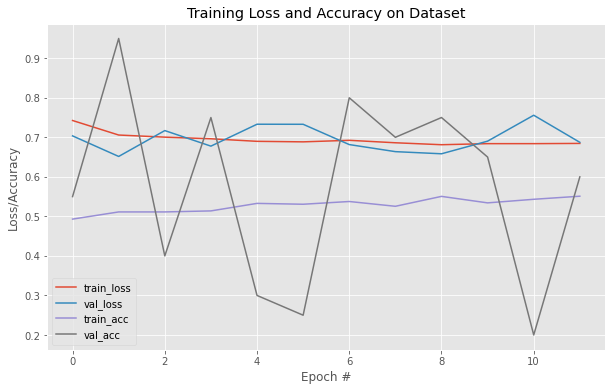

In [28]:
plot_history(history)

- There was an early stop after 12. epoch.
- The training accuracy is only a bit better than random choice.
- The validation loss and accuracy are very unstable.

    Model needs improvement.

In [29]:
## Trainig the 2nd model:
weight_path_2 ="{}_model_2.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path_2, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor='val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

# Defining a new model (based on the same pretrained model) with lower learning rate
model_2 = build_model(model_1_pretrained, lr=1e-5)

Epoch 1/40
116/116 [==============================] - 64s 550ms/step - loss: 0.7613 - binary_accuracy: 0.4818 - val_loss: 0.5671 - val_binary_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.56707, saving model to xray_class_my_model_2.best.hdf5
Epoch 2/40
116/116 [==============================] - 74s 638ms/step - loss: 0.7115 - binary_accuracy: 0.5169 - val_loss: 0.5198 - val_binary_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.56707 to 0.51978, saving model to xray_class_my_model_2.best.hdf5
Epoch 3/40
116/116 [==============================] - 74s 635ms/step - loss: 0.7175 - binary_accuracy: 0.4974 - val_loss: 0.5404 - val_binary_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.51978
Epoch 4/40
116/116 [==============================] - 58s 498ms/step - loss: 0.7084 - binary_accuracy: 0.5156 - val_loss: 0.5493 - val_binary_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.51978
Epoch 5/40
116/116 [==============================] - 

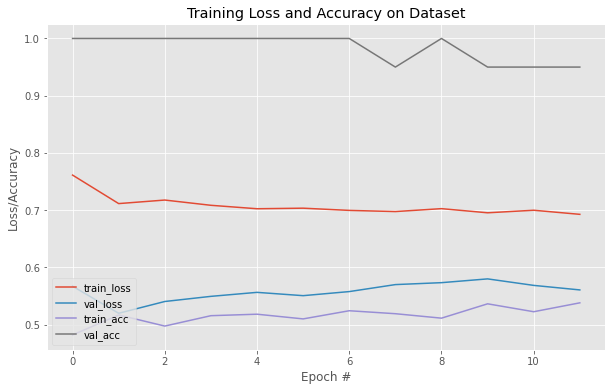

In [30]:
# Fitting the model and monitoring its performance
history_2 = model_2.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 40, 
                          callbacks = callbacks_list)
plot_history(history_2)

- There was an early stop after 12. epoch.
- The training accuracy is a bit better than random choice.
- The validation accuracy is very high.

    
    As the validation set consists of only 1.2% positive pneumonia cases, the high accuracy can reflect classification of almost all images as negative. Thus other metrics like sensitivity and specificity should be checked.

In [31]:
# Training 3rd model, unfreezing 4 more layers in VGG16 network
weight_path_3 ="{}_model_3.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path_3, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor='val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

model_3_pretrained = load_pretrained_model(transfer_layer='block4_pool', transfer_layer_idx=14)
model_3 = build_model(model_3_pretrained, lr=0.00001)

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool True


Epoch 1/40
116/116 [==============================] - 54s 468ms/step - loss: 0.9468 - binary_accuracy: 0.5056 - val_loss: 0.7176 - val_binary_accuracy: 0.4500

Epoch 00001: val_loss improved from inf to 0.71764, saving model to xray_class_my_model_3.best.hdf5
Epoch 2/40
116/116 [==============================] - 54s 462ms/step - loss: 0.7572 - binary_accuracy: 0.5173 - val_loss: 0.6809 - val_binary_accuracy: 0.5500

Epoch 00002: val_loss improved from 0.71764 to 0.68086, saving model to xray_class_my_model_3.best.hdf5
Epoch 3/40
116/116 [==============================] - 54s 461ms/step - loss: 0.7140 - binary_accuracy: 0.5251 - val_loss: 0.7210 - val_binary_accuracy: 0.3000

Epoch 00003: val_loss did not improve from 0.68086
Epoch 4/40
116/116 [==============================] - 53s 458ms/step - loss: 0.7118 - binary_accuracy: 0.5156 - val_loss: 0.6619 - val_binary_accuracy: 0.7000

Epoch 00004: val_loss improved from 0.68086 to 0.66188, saving model to xray_class_my_model_3.best.hdf5
E

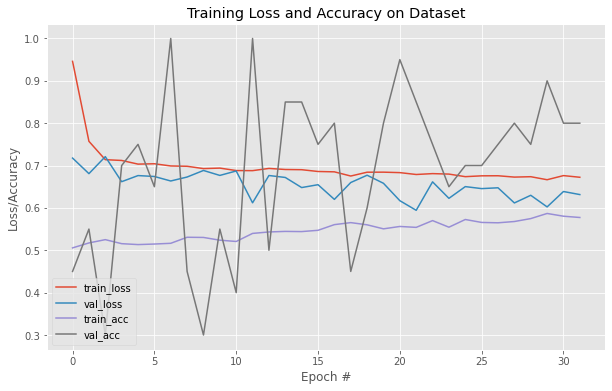

In [32]:
history_3 = model_3.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 40, 
                          callbacks = callbacks_list)
plot_history(history_3)

- Model 3 also does not have high training accuracy 
- The validation loss and accuracy are noisy.

    Model needs improvement.

In [35]:
## Saving model architecture to a .json:

model_1_json = model_1.to_json()
with open("model_1.json", "w") as json_file:
    json_file.write(model_1_json)
    
model_2_json = model_2.to_json()
with open("model_2.json", "w") as json_file:
    json_file.write(model_2_json)
    
model_3_json = model_3.to_json()
with open("model_3.json", "w") as json_file:
    json_file.write(model_3_json)

Ideas on the next steps:

- Testing different approach to training set: instead of removing most of the negative cases in order to have a balanced data set, introducing weighted loss
- Introduce cross-validation
- Training without image augmentation
- Changing batch sizes
- Testing other pre-trained models (e.g. ResNet50) 
- Testing differently frozen / unfrozen layers
- Implementing gradcam to see, what areas are most meaningful for the algorithm
  (https://keras.io/examples/vision/grad_cam/)
- Changing the Dropout parameter 
- Changing the number of Dense Layers and the number of neurons within each.
- Checking models performance using sensitivity, specificity and F1 score